# Wind Power Forecasting: Explore Phase


Perform an exploratory analysis of the Spatial Dynamic Wind Power Forecasting or [SDWPF dataset](https://arxiv.org/abs/2208.04360), which contains data from 134 wind turbines in a wind farm in China. The SDWPF data was provided by the Longyuan Power Group, which is the largest wind power producer in China and Asia.




## 1. Import Python packages

Run the next cell to import that Python packages neede.

Note the `import utils` line. This line imports the functions that were specifically written for the analysis, which is not included here.

In [1]:
import pandas as pd # package for reading in and manipulating the data
import seaborn as sns # package for data visualization
import ipywidgets as widgets # package for creating interactive visuals
import matplotlib.pyplot as plt # package for making plots
from IPython.display import display # package for displaying visuals
#import utils # utility functions provided for this lab
import random
import numpy as np
from datetime import datetime, timedelta
from ipywidgets import interact
from typing import List, Iterable, Callable, Tuple, Dict, Optional
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.inspection import permutation_importance
from ipywidgets import interact, interact_manual, fixed
import tensorflow as tf
from dataclasses import dataclass
import pickle


FONT_SIZE_TICKS = 15
FONT_SIZE_TITLE = 25
FONT_SIZE_AXES = 20

print('All packages imported successfully!')

All packages imported successfully!


In [3]:
#access files in my Google Drive to read in file correctly
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load the dataset


The dataset contains information of 134 turbines in a wind farm. Run the next cell to read in the data.

In [4]:
# Load the data from the csv file
raw_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/wind power/explore data/data/wtbdata_245days.csv")

# Add units to numerical features
raw_data.columns = ["TurbID", "Day", "Tmstamp", "Wspd (m/s)", "Wdir (°)", "Etmp (°C)", "Itmp (°C)", "Ndir (°)", "Pab1 (°)", "Pab2 (°)", "Pab3 (°)", "Prtv (kW)", "Patv (kW)"]

# Print the first 5 rows of the dataset
raw_data.head(5)

TurbID  Day Tmstamp  Wspd (m/s)  Wdir (°)  Etmp (°C)  Itmp (°C)  Ndir (°)  \
0       1    1   00:00         NaN       NaN        NaN        NaN       NaN   
1       1    1   00:10        6.17     -3.99      30.73      41.80     25.92   
2       1    1   00:20        6.27     -2.18      30.60      41.63     20.91   
3       1    1   00:30        6.42     -0.73      30.52      41.52     20.91   
4       1    1   00:40        6.25      0.89      30.49      41.38     20.91   

   Pab1 (°)  Pab2 (°)  Pab3 (°)  Prtv (kW)  Patv (kW)  
0       NaN       NaN       NaN        NaN        NaN  
1       1.0       1.0       1.0      -0.25     494.66  
2       1.0       1.0       1.0      -0.24     509.76  
3       1.0       1.0       1.0      -0.26     542.53  
4       1.0       1.0       1.0      -0.23     509.36

THis [paper](https://arxiv.org/abs/2208.04360) contains more information about the dataset.

Every entry (or row) in the dataset contains the following information:

- `TurbID`: Wind turbine identification number.


- `Day`: The number of the day represented as a string (first day is May 1st 2020).


- `Tmstamp`: The hour and minute of the date of the measurement.


- `Wspd`: The wind speed recorded by the anemometer measured in meters per second.


- `Wdir`: The angle between the wind direction and the position of turbine nacelle measured in degrees.


- `Etmp`: Temperature of the surounding environment measured in degrees Celsius.


- `Itmp`: Temperature inside the turbine nacelle measured in degrees Celsius.


- `Ndir`: Nacelle direction, i.e., the yaw angle of the nacelle measured in degrees.


- `Pab1`: Pitch angle of blade 1 measured in degrees.


- `Pab2`: Pitch angle of blade 2 measured in degrees.


- `Pab3`: Pitch angle of blade 3 measured in degrees.


- `Prtv`: Reactive power measured in kW.


- `Patv`: Active power measured in kW → **note: this is the target variable you will be trying to predict**.


## 3. Inspect and address missing values

Run the next cell to print the number of missing values per column in the dataset.

In [5]:
# Print missing values per feature
print("Number of missing values per column:\n")
print(raw_data.isnull().sum())

# Dataframe with only missing values
mv = raw_data[raw_data.isnull().any(axis=1)]

# Compute missing and total values
num_na_values, total_values = len(mv), len(raw_data)
print(f"\nThe dataset contains {total_values} rows, of which {num_na_values} are missing.\n\nThis is {(num_na_values/total_values)*100:.3f}% of the total data.")

Number of missing values per column:

TurbID            0
Day               0
Tmstamp           0
Wspd (m/s)    49518
Wdir (°)      49518
Etmp (°C)     49518
Itmp (°C)     49518
Ndir (°)      49518
Pab1 (°)      49518
Pab2 (°)      49518
Pab3 (°)      49518
Prtv (kW)     49518
Patv (kW)     49518
dtype: int64

The dataset contains 4727520 rows, of which 49518 are missing.

This is 1.047% of the total data.


Run the next cell to drop rows that contain missing values.

In [8]:
# Drop missing values
raw_data = raw_data.dropna()

# Print missing values per feature
print("Number of missing values per feature:\n")
print(raw_data.isnull().sum())

Number of missing values per feature:

TurbID        0
Day           0
Tmstamp       0
Wspd (m/s)    0
Wdir (°)      0
Etmp (°C)     0
Itmp (°C)     0
Ndir (°)      0
Pab1 (°)      0
Pab2 (°)      0
Pab3 (°)      0
Prtv (kW)     0
Patv (kW)     0
dtype: int64


## 4. Calculate descriptive statistics

Look at descriptive statistics for the data. This only makes sense for numerical features so you will first separate these from all the available features:

In [9]:
# Make a list of all columns in the dataset
all_features = list(raw_data.columns)
# Make a list of only the columns containing numerical features
numerical_features = [f for f in all_features if f not in ["TurbID", "Day", "Tmstamp"]]

print(f"The numerical features are:\n\n{numerical_features}")

The numerical features are:

['Wspd (m/s)', 'Wdir (°)', 'Etmp (°C)', 'Itmp (°C)', 'Ndir (°)', 'Pab1 (°)', 'Pab2 (°)', 'Pab3 (°)', 'Prtv (kW)', 'Patv (kW)']


In [10]:
# Create a dataframe with descriptive statistics
descriptive_stats = raw_data[numerical_features].describe()
# Format the dataframe to show three decimal places and display the dataframe
descriptive_stats.apply(lambda s: s.apply('{0:.3f}'.format))

Wspd (m/s)     Wdir (°)    Etmp (°C)    Itmp (°C)     Ndir (°)  \
count  4678002.000  4678002.000  4678002.000  4678002.000  4678002.000   
mean         5.028        0.498       41.107       27.397      188.583   
std          3.394       31.603       85.290       18.328      163.246   
min          0.000    -3030.460     -273.030     -273.170     -884.860   
25%          2.240       -3.830       14.050       20.060       63.020   
50%          4.340       -0.230       25.730       30.080      194.790   
75%          7.010        3.420       32.730       36.820      321.960   
max         26.290     2266.950      394.330      324.210      700.620   

          Pab1 (°)     Pab2 (°)     Pab3 (°)    Prtv (kW)    Patv (kW)  
count  4678002.000  4678002.000  4678002.000  4678002.000  4678002.000  
mean        26.854       26.839       26.827      -13.239      350.446  
std         38.836       38.829       38.822       70.442      424.993  
min        -10.000      -10.000      -10.000     -624.980       -9.330  
25%          0.010        0.010        0.010      -38.610       -0.300  
50%          0.540        0.540        0.540       -0.300      179.080  
75%         83.990       83.980       83.980       -0.030      547.660  
max         99.980       99.980       99.980      485.200     1567.020

## 5. Select a subset of turbines

For data exploration purposes, run the next cell to select a subset (default to 10) of the top performing (in terms of energy output) wind turbines on the wind farm in order to investigate the data in more detail.

In [12]:
# Keep the data for a 10-turbine wind farm
top_turbines = top_n_turbines(raw_data, 10)

Original data has 4678002 rows from 134 turbines.

Sliced data has 349365 rows from 10 turbines.


## 6. Visualize the data

### 6.1 Histograms

 Run the next cell to plot a histogram of the different features for the turbines you selected. The pulldown menus are to select different numerical features and different turbines.

In [14]:
# @title
# Define a number of bins to use (feel free to changes this and see what happens!)
bin_size=64

# Generate histograms
histogram_plot(top_turbines, numerical_features, bin_size)

interactive(children=(Dropdown(description='Turbine', index=9, options=(np.int64(1), np.int64(3), np.int64(4),…

#### Histogram comparison between two turbines

Run the next cell to compare histogram distributions between two turbines for numerical features in the dataset.

In [17]:
# Define a number of bins to use (this can be changed and see what happens!)
bin_size=32

# Generate histograms
histogram_comparison_plot(top_turbines, numerical_features, bin_size)

interactive(children=(Dropdown(description='Turbine ID', index=8, options=(np.int64(1), np.int64(3), np.int64(…

### 6.2 Box plots and violin plots

Select "violin" in the plot type pulldown menu to visualize your data as violin plots. Violin plots will show you the distribution of your data in a similar way to histograms. You can think of them as histograms rotated sideways and mirrored along the vertical axis.

Select "box" in the plot type pulldown menu to visualize your data as box plots.  For box plots, each box shows the median (horizontal line through the middle of the box) and middle 50% (vertical range of the box) of your data. Here you are generating one boxplot for each turbine.


Run the next cell to generate plots and use the pulldown menu select the type of plot (box or violin).

In [19]:
# Generate the box/violin plots across all turbines
box_violin_plot(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Feature', options=('Wspd (m/s)', 'Wdir (°)', 'Etmp (°C)', 'Itmp (°…

### 6.3 Scatterplots

Scatterplots are useful for looking at the relationship (or lack thereof) between two variables. Run the cell below to generate scatterplots and use the pulldown menus to investigate the relationship between different features. Pay special attention to the relationship of each feature agains `Patv (kW)` as this is the feature trying to predict.

Use the pulldown menu to select a turbine and the features to plot against each other.

In [21]:
# Generate the per turbine scatterplot for any two features
scatterplot(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine', index=9, options=(np.int64(1), np.int64(3), np.int64(4),…

### 6.4 Pairplot

In the next cell you will see a grid of plots with each of the numerical features listed along both the vertical and horizontal axes. In each cell of the grid you'll find either a histogram (where the feature listed on the vertical and horizontal axes is the same) or a scatterplot showing the feature listed on the vertical axis plotted against the one shown on the horizontal axis. This can be a nice way of investigating distributions and relationships between all the features quickly.

Note that as a result of the amount of data, this plot takes a somewhat long time to run. For this there is no interactive menu to run the cell so if you wish to generate the plot for a different turbine you need to manually change the value and then run the cell.

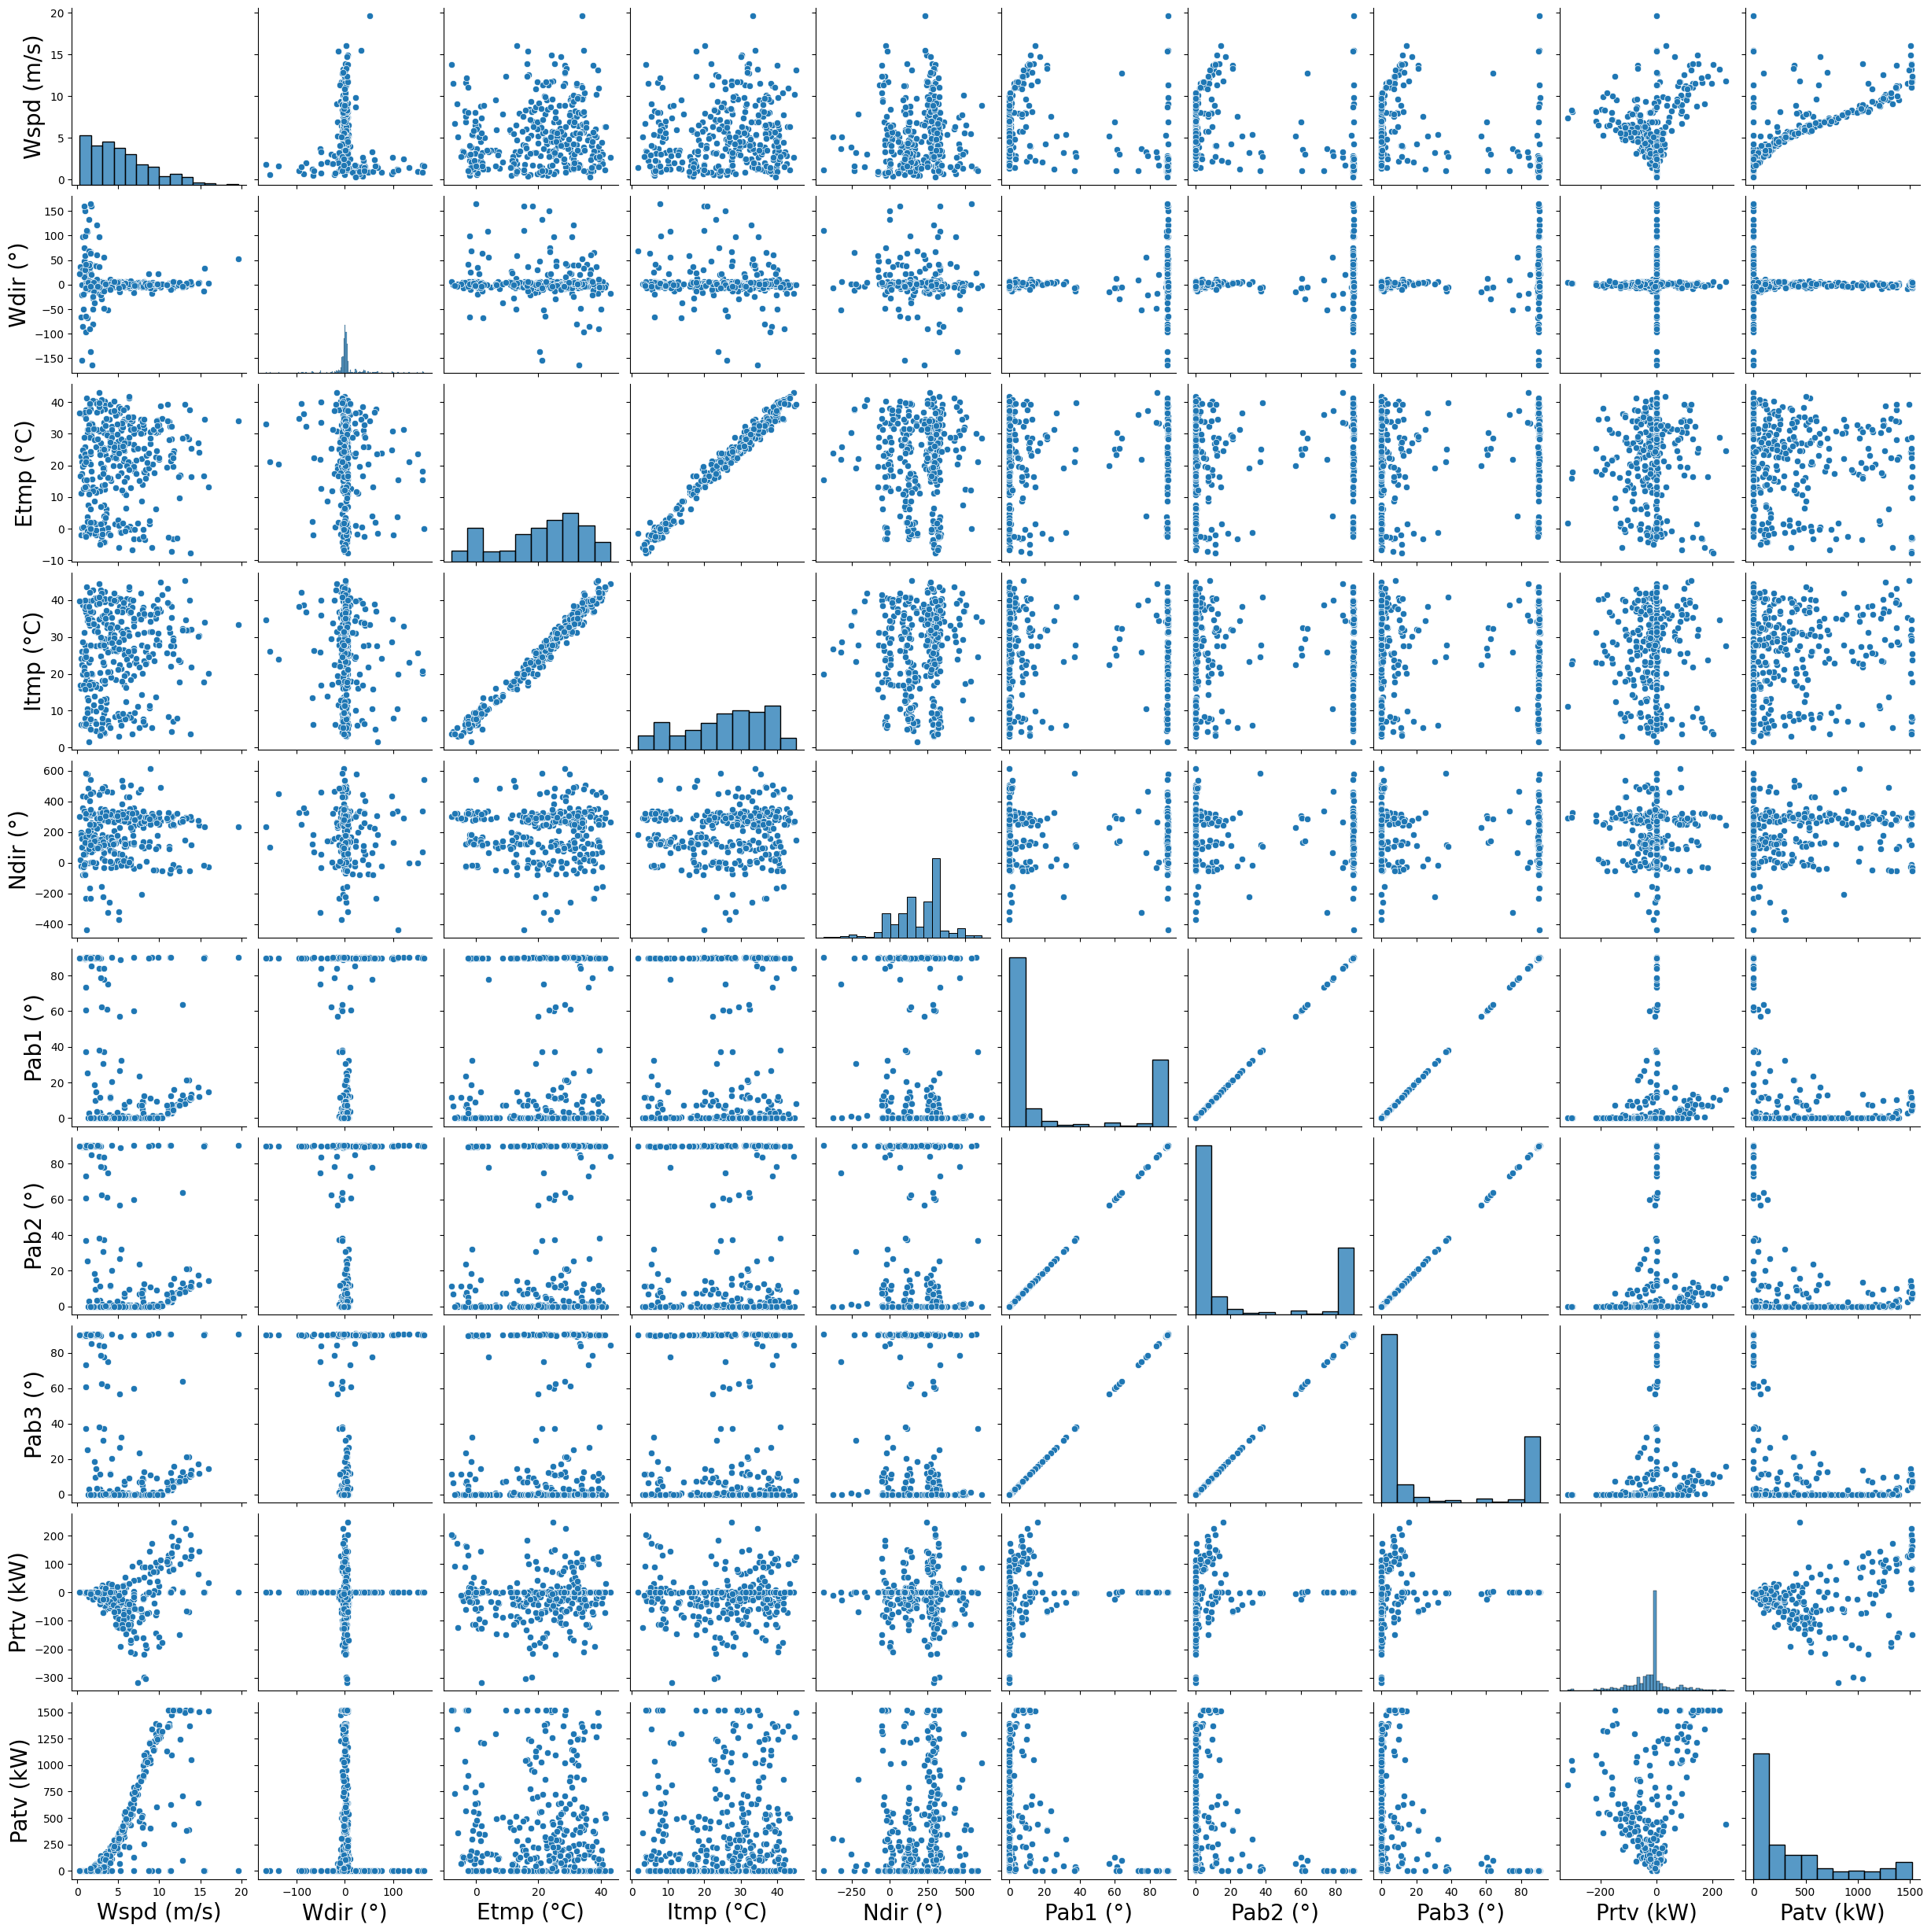

In [23]:
# Identify a turbine and fraction of data to plot (you can changes these values!)
turb_id = 10     # the id of the turbine
fraction = 0.01 # the fraction of the rows to include in the plot

plot_pairplot(top_turbines, turb_id, numerical_features, fraction)

### 6.5 Correlation matrix


A correlation matrix is used to see how different variables correlate with each other. The [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) calculated below is measured between -1 and 1. Numbers closer to 1 or -1 indicate higher levels of correlation between two variables, while values close to 0 indicate no significant correlation between two variables. You can ignore the 1's along the diagonal as those just represent the correlation of each variable with itself.

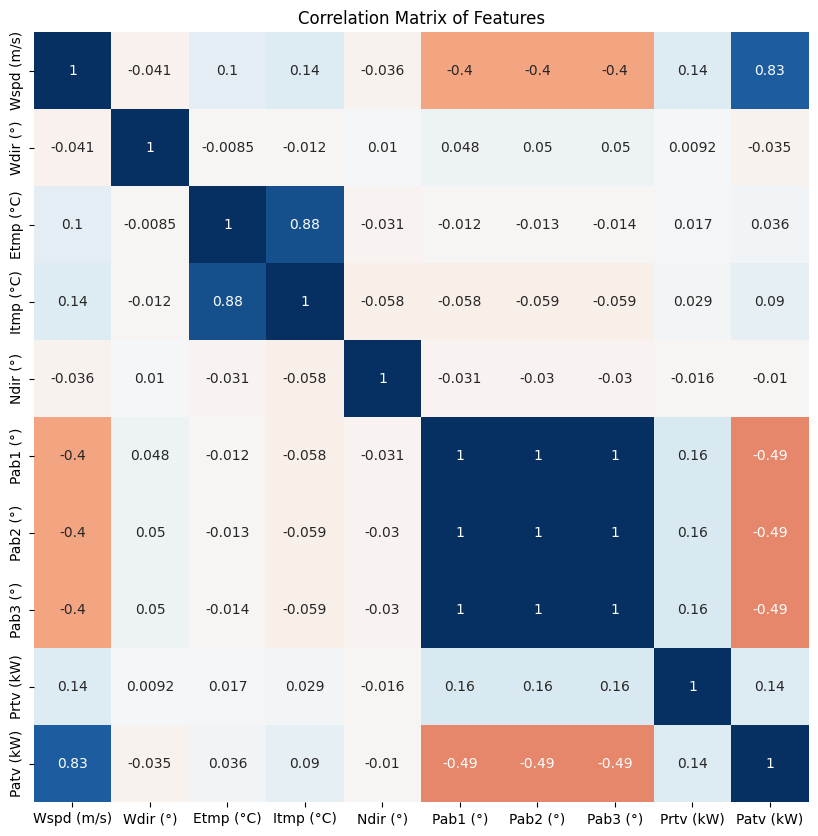

In [25]:
# Generate a corrlation matrix
correlation_matrix(top_turbines[numerical_features])

### 6.6  Time Series

#### Format date and time


Right now the data has the day and the time encoded as separate features. To plot a time series of the data it makes more sense to have a single feature with the combined "datetime" information of each record. You can do this by running the next cell. It is found that day 1 corresponds to May 1st 2020, which is used to convert day number to a proper date.

In [27]:
# Create proper datetimes (this takes around 15 secs)
raw_data = format_datetime(top_turbines, initial_date_str="01 05 2020")

raw_data.head(5)

<ipython-input-26-b9e83bdcd753>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = data.apply(
<ipython-input-26-b9e83bdcd753>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Datetime"] = data.apply(
<ipython-input-26-b9e83bdcd753>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(["Day", "Tm

Datetime  TurbID  Wspd (m/s)  Wdir (°)  Etmp (°C)  Itmp (°C)  \
1 2020-05-01 00:10:00       1        6.17     -3.99      30.73      41.80   
2 2020-05-01 00:20:00       1        6.27     -2.18      30.60      41.63   
3 2020-05-01 00:30:00       1        6.42     -0.73      30.52      41.52   
4 2020-05-01 00:40:00       1        6.25      0.89      30.49      41.38   
5 2020-05-01 00:50:00       1        6.10     -1.03      30.47      41.22   

   Ndir (°)  Pab1 (°)  Pab2 (°)  Pab3 (°)  Prtv (kW)  Patv (kW)  
1     25.92       1.0       1.0       1.0      -0.25     494.66  
2     20.91       1.0       1.0       1.0      -0.24     509.76  
3     20.91       1.0       1.0       1.0      -0.26     542.53  
4     20.91       1.0       1.0       1.0      -0.23     509.36  
5     20.91       1.0       1.0       1.0      -0.27     482.21

#### Plot time series

Run the cell below to generate a plot of features over the time span of the data for a particular turbine. Use the pulldown menus to choose different turbines and features. Use the sliders to zoom in or out on a particular range of dates.

Both `Etmp (°C)` and `Itmp (°C)` have really negative values which are most likely caused by errors on the sensors. These values make it hard to visualize the actual time series for these features so there is a toggle `fix temperatures` below to replace these by the values produced by using a linear interpolation.

In [30]:
# Generate a time series plot of features for a paricular turbine
plot_time_series(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine ID', index=9, options=(np.int64(1), np.int64(3), np.int64(…

####  Time Series for a pair of turbines

Take a look at the time series for any pair of turbines. This is helpful to identify weird behaviours for a particular turbine or to check erratic behaviour in features that should behave very similar since they are not turbine-specific such as the external temperature.

In [32]:
# Generate a time series plot of features for a pair of turbines
time_series_turbine_pair(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine ID', index=8, options=(np.int64(1), np.int64(3), np.int64(…

# Wind Power Forecasting: Feature Engineering


## 7. Catalog abnormal values

Some values should be excluded from the analysis because they are either `missing`, `unknown` or `abnormal`.

`missing` values are self explanatory but here are the definitions for the other two types:

`unknown`:
- if `Patv` ≤ 0 and `Wspd` > 2.5
- if `Pab1` > 89° or `Pab2` > 89° or `Pab3` > 89°

`abnormal`:
- if `Ndir` < -720 or `Ndir` > 720
- if `Wdir` < -180 or `Wdir` > 180

Create a new column called `Include` in the dataframe and set the value to False for every `missing / unknown / abnormal` value:

In [34]:
top_turbines = top_turbines.rename(columns={'Wspd (m/s)':'Wspd','Wdir (°)':'Wdir','Etmp (°C)':'Etmp','Itmp (°C)':'Itmp','Ndir (°)':'Ndir',
                     'Pab1 (°)':'Pab1','Pab2 (°)':'Pab2','Pab3 (°)':'Pab3','Prtv (kW)':'Prtv','Patv (kW)':'Patv'})
top_turbines.columns

Index(['TurbID', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2',
       'Pab3', 'Prtv', 'Patv', 'Datetime'],
      dtype='object')

In [35]:
# Initially include all rows
top_turbines["Include"] = True

# Define conditions for abnormality
conditions = [
    np.isnan(top_turbines.Patv),
    (top_turbines.Pab1 > 89) | (top_turbines.Pab2 > 89) | (top_turbines.Pab3 > 89),
    (top_turbines.Ndir < -720) | (top_turbines.Ndir > 720),
    (top_turbines.Wdir < -180) | (top_turbines.Wdir > 180),
    (top_turbines.Patv <= 0) & (top_turbines.Wspd > 2.5)
]

# Exclude abnormal features
for condition in conditions:
    top_turbines = tag_abnormal_values(top_turbines, condition)

top_turbines.head()

TurbID  Wspd  Wdir   Etmp   Itmp   Ndir  Pab1  Pab2  Pab3  Prtv    Patv  \
1       1  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0 -0.25  494.66   
2       1  6.27 -2.18  30.60  41.63  20.91   1.0   1.0   1.0 -0.24  509.76   
3       1  6.42 -0.73  30.52  41.52  20.91   1.0   1.0   1.0 -0.26  542.53   
4       1  6.25  0.89  30.49  41.38  20.91   1.0   1.0   1.0 -0.23  509.36   
5       1  6.10 -1.03  30.47  41.22  20.91   1.0   1.0   1.0 -0.27  482.21   

             Datetime  Include  
1 2020-05-01 00:10:00     True  
2 2020-05-01 00:20:00     True  
3 2020-05-01 00:30:00     True  
4 2020-05-01 00:40:00     True  
5 2020-05-01 00:50:00     True

Now run the next cell to create the `clean_data` dataframe which no longer includes all data since abnormal values have been removed:

In [36]:
# Cut out all abnormal values
clean_data = top_turbines[top_turbines.Include].drop(["Include"], axis=1)

clean_data.head()

TurbID  Wspd  Wdir   Etmp   Itmp   Ndir  Pab1  Pab2  Pab3  Prtv    Patv  \
1       1  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0 -0.25  494.66   
2       1  6.27 -2.18  30.60  41.63  20.91   1.0   1.0   1.0 -0.24  509.76   
3       1  6.42 -0.73  30.52  41.52  20.91   1.0   1.0   1.0 -0.26  542.53   
4       1  6.25  0.89  30.49  41.38  20.91   1.0   1.0   1.0 -0.23  509.36   
5       1  6.10 -1.03  30.47  41.22  20.91   1.0   1.0   1.0 -0.27  482.21   

             Datetime  
1 2020-05-01 00:10:00  
2 2020-05-01 00:20:00  
3 2020-05-01 00:30:00  
4 2020-05-01 00:40:00  
5 2020-05-01 00:50:00

## 8. Establish a baseline for wind power estimation

Create a baseline for wind power estimation using a `linear regression` model to fit the relationship between wind speed and power output.  Use the dropdown to train a linear model for one of the turbines and see how it performs by looking at a plot of predicted vs actual power output values and mean absolute error for the model.

In [38]:
linear_univariate_model(clean_data)

interactive(children=(Dropdown(description='Turbine', options=(np.int64(1), np.int64(3), np.int64(4), np.int64…

## 9. Feature engineering

Before building a model capable of estimating power output from the other features we need to perform some `Feature Engineering`. During this process we will transform the existing features into better representations, combine features, fix issues with them and create new features.

### 9.1  Delete redundant features - Pab

In the previous analysis we saw that all the `Pab#` features (which stands for `pitch angle blade #`) were perfectly correlated, which means that they are redundant. We can instead keep only one of these features and rename it as `Pab`. Run the next cell to keep only 1 column of `Pab` features.

In [40]:
# Aggregate pab features
clean_data = cut_pab_features(clean_data)

clean_data.head(5)

TurbID  Wspd  Wdir   Etmp   Itmp   Ndir  Pab  Prtv    Patv  \
1       1  6.17 -3.99  30.73  41.80  25.92  1.0 -0.25  494.66   
2       1  6.27 -2.18  30.60  41.63  20.91  1.0 -0.24  509.76   
3       1  6.42 -0.73  30.52  41.52  20.91  1.0 -0.26  542.53   
4       1  6.25  0.89  30.49  41.38  20.91  1.0 -0.23  509.36   
5       1  6.10 -1.03  30.47  41.22  20.91  1.0 -0.27  482.21   

             Datetime  
1 2020-05-01 00:10:00  
2 2020-05-01 00:20:00  
3 2020-05-01 00:30:00  
4 2020-05-01 00:40:00  
5 2020-05-01 00:50:00

### 9.2 Transform angle features

There are 3 features (`Wdir`, `Ndir`, `Pab`) which are encoded in degrees. This is problematic because your model has no way of knowing that angles with very different values (such as 0° and 360°) are actually very similar (the same in this case) to each other. To address this you can transform these features into their `sine`/`cosine` representations.

Run the next cell to convert angle features to their `sine`/`cosine` representations.

In [42]:
# Transform all angle-encoded features
for feature in ["Wdir", "Ndir", "Pab"]:
    transform_angles(clean_data, feature)

clean_data.head(5)

TurbID  Wspd   Etmp   Itmp  Prtv    Patv            Datetime   WdirCos  \
1       1  6.17  30.73  41.80 -0.25  494.66 2020-05-01 00:10:00  0.997576   
2       1  6.27  30.60  41.63 -0.24  509.76 2020-05-01 00:20:00  0.999276   
3       1  6.42  30.52  41.52 -0.26  542.53 2020-05-01 00:30:00  0.999919   
4       1  6.25  30.49  41.38 -0.23  509.36 2020-05-01 00:40:00  0.999879   
5       1  6.10  30.47  41.22 -0.27  482.21 2020-05-01 00:50:00  0.999838   

    WdirSin   NdirCos   NdirSin    PabCos    PabSin  
1 -0.069582  0.899405  0.437116  0.999848  0.017452  
2 -0.038039  0.934142  0.356901  0.999848  0.017452  
3 -0.012741  0.934142  0.356901  0.999848  0.017452  
4  0.015533  0.934142  0.356901  0.999848  0.017452  
5 -0.017976  0.934142  0.356901  0.999848  0.017452

### 9.3 Fix temperatures and active power

Both `Etmp` and `Itmp` had really negative values. In fact, these minimum values are very close to the absolute zero (-273.15 °C) which is most certainly an error. Here we will use linear interpolation to fix these values.

Active power has negative values which doesn't make sense in the context of the problem at hand. All negative values should be treated as zero.

Apply these changes by running the following cell:

In [44]:
# Fix temperature values
clean_data = fix_temperatures(clean_data)

# Fix negative active powers
clean_data["Patv"] = clean_data["Patv"].apply(lambda x: max(0, x))

clean_data.head(5)

TurbID  Wspd   Etmp   Itmp  Prtv    Patv            Datetime   WdirCos  \
1       1  6.17  30.73  41.80 -0.25  494.66 2020-05-01 00:10:00  0.997576   
2       1  6.27  30.60  41.63 -0.24  509.76 2020-05-01 00:20:00  0.999276   
3       1  6.42  30.52  41.52 -0.26  542.53 2020-05-01 00:30:00  0.999919   
4       1  6.25  30.49  41.38 -0.23  509.36 2020-05-01 00:40:00  0.999879   
5       1  6.10  30.47  41.22 -0.27  482.21 2020-05-01 00:50:00  0.999838   

    WdirSin   NdirCos   NdirSin    PabCos    PabSin  
1 -0.069582  0.899405  0.437116  0.999848  0.017452  
2 -0.038039  0.934142  0.356901  0.999848  0.017452  
3 -0.012741  0.934142  0.356901  0.999848  0.017452  
4  0.015533  0.934142  0.356901  0.999848  0.017452  
5 -0.017976  0.934142  0.356901  0.999848  0.017452

### 9.4 Create time features

Create features that encode the time-of-day signals for each data point in the dataset.Check out this [post](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/) for a better understanding of why this is needed.

In [46]:
# Generate time signals
clean_data = generate_time_signals(clean_data)

clean_data.head(5)

TurbID  Wspd   Etmp   Itmp  Prtv    Patv            Datetime   WdirCos  \
1       1  6.17  30.73  41.80 -0.25  494.66 2020-05-01 00:10:00  0.997576   
2       1  6.27  30.60  41.63 -0.24  509.76 2020-05-01 00:20:00  0.999276   
3       1  6.42  30.52  41.52 -0.26  542.53 2020-05-01 00:30:00  0.999919   
4       1  6.25  30.49  41.38 -0.23  509.36 2020-05-01 00:40:00  0.999879   
5       1  6.10  30.47  41.22 -0.27  482.21 2020-05-01 00:50:00  0.999838   

    WdirSin   NdirCos   NdirSin    PabCos    PabSin  Time-of-day sin  \
1 -0.069582  0.899405  0.437116  0.999848  0.017452         0.043619   
2 -0.038039  0.934142  0.356901  0.999848  0.017452         0.087156   
3 -0.012741  0.934142  0.356901  0.999848  0.017452         0.130526   
4  0.015533  0.934142  0.356901  0.999848  0.017452         0.173648   
5 -0.017976  0.934142  0.356901  0.999848  0.017452         0.216440   

   Time-of-day cos  
1         0.999048  
2         0.996195  
3         0.991445  
4         0.984808  
5         0.976296

Run the next cell to do a final step to prepare the data for modeling.

In [48]:
# Define predictor features
predictors = [f for f in clean_data.columns if f not in ["Datetime", "TurbID", "Patv"]]

# Define target feature
target = ["Patv"]

# Re-arrange features before feeding into models
model_data = clean_data[["TurbID"]+predictors+target]

model_data.head(5)

TurbID  Wspd   Etmp   Itmp  Prtv   WdirCos   WdirSin   NdirCos   NdirSin  \
1       1  6.17  30.73  41.80 -0.25  0.997576 -0.069582  0.899405  0.437116   
2       1  6.27  30.60  41.63 -0.24  0.999276 -0.038039  0.934142  0.356901   
3       1  6.42  30.52  41.52 -0.26  0.999919 -0.012741  0.934142  0.356901   
4       1  6.25  30.49  41.38 -0.23  0.999879  0.015533  0.934142  0.356901   
5       1  6.10  30.47  41.22 -0.27  0.999838 -0.017976  0.934142  0.356901   

     PabCos    PabSin  Time-of-day sin  Time-of-day cos    Patv  
1  0.999848  0.017452         0.043619         0.999048  494.66  
2  0.999848  0.017452         0.087156         0.996195  509.76  
3  0.999848  0.017452         0.130526         0.991445  542.53  
4  0.999848  0.017452         0.173648         0.984808  509.36  
5  0.999848  0.017452         0.216440         0.976296  482.21

## 10. Update linear model baseline with more features

Use the dropdown to select the turbine to model and choose from the list of features you want to include in the model. Use the shift and arrow keys on your keyboard to select the features you wish to include and then click on the `Run Interact` button to train your model.


In [50]:
# Create a linear model with more features
linear_multivariate_model(model_data, predictors)
# Running the interaction below might take a minute

interactive(children=(Dropdown(description='Turbine', options=(np.int64(1), np.int64(3), np.int64(4), np.int64…

## 11. Use a neural network to improve wind power estimation

Train a neural network model for comparison. Click on the `Run Interact` button to train the network and output the results.

In [52]:
# Train a neural network model
neural_network(model_data, predictors)
# Running the interaction below might take a minute

interactive(children=(Dropdown(description='Turbine', options=(np.int64(1), np.int64(3), np.int64(4), np.int64…

# Wind Power Forecasting: Prediction Phase

Compare different forecasting techniques to **predict the power output of one turbine for the next 24 hours**. Note that this process could be replicated for all the turbines to predict the total power output of your wind farm. The Tensorflow framework is used to make forecasts and draws inspiration from their [official guide](https://www.tensorflow.org/tutorials/structured_data/time_series) on time series forecasting.

## 12. Load the dataset saved after feature engineering

Run the next cell to load your the dataset after performing feature engineering in the previous sections.

In [53]:
# Load the data into a pandas dataframe
curated_data = pd.read_csv("drive/MyDrive/Colab Notebooks/wind power/forecast/data/wind_data.csv")

# Print out the turbines that are included in the dataset
print(f'Turbines included in the dataset: {curated_data.TurbID.unique()}')

curated_data.head(5)

Turbines included in the dataset: [ 1  3  4  5  6  9 10 11 12 70]


Datetime  TurbID  Wspd   Etmp   Itmp  Prtv    Patv  Include  \
0  2020-05-01 00:00:00       1   NaN    NaN    NaN   NaN    0.00    False   
1  2020-05-01 00:10:00       1  6.17  30.73  41.80 -0.25  494.66     True   
2  2020-05-01 00:20:00       1  6.27  30.60  41.63 -0.24  509.76     True   
3  2020-05-01 00:30:00       1  6.42  30.52  41.52 -0.26  542.53     True   
4  2020-05-01 00:40:00       1  6.25  30.49  41.38 -0.23  509.36     True   

    WdirCos   WdirSin   NdirCos   NdirSin    PabCos    PabSin  
0       NaN       NaN       NaN       NaN       NaN       NaN  
1  0.997576 -0.069582  0.899405  0.437116  0.999848  0.017452  
2  0.999276 -0.038039  0.934142  0.356901  0.999848  0.017452  
3  0.999919 -0.012741  0.934142  0.356901  0.999848  0.017452  
4  0.999879  0.015533  0.934142  0.356901  0.999848  0.017452

## 13. Slice your data and resample to an hourly frequency

Select just one turbine to train and test your models, but we can change the `turb_id` parameter below to replicate the same process for any of the top ten turbines to get the power output for each, and in principle, this could be extended to the entire wind farm. We'll also reduce the cadence of the data by sampling at hourly intervals (down from 10 min intervals in the original data). Run the next cell to prepare your data for the forecasting process.

In [55]:
# Select the turbine you will use
turb_id = 6

# Prepare data for feeding into the network
data = prepare_data(curated_data, turb_id)

data.head(5)

Wspd   Etmp   Itmp  Prtv   WdirCos   WdirSin   NdirCos  \
Datetime                                                                      
2020-05-01 00:50:00  6.37  30.77  37.90 -0.10  0.999397 -0.034725  0.530955   
2020-05-01 01:50:00  6.92  30.04  37.13 -0.06  0.989751 -0.142802  0.530955   
2020-05-01 02:50:00  7.16  29.98  36.89 -0.13  0.983064 -0.183265  0.701904   
2020-05-01 03:50:00  7.44  30.00  36.62 -0.09  0.996285 -0.086112  0.819152   
2020-05-01 04:50:00  9.58  30.24  35.71 -0.14  0.999693 -0.024781  0.839146   

                      NdirSin    PabCos    PabSin    Patv  
Datetime                                                   
2020-05-01 00:50:00  0.847400  1.000000  0.000524  501.54  
2020-05-01 01:50:00  0.847400  1.000000  0.000349  502.57  
2020-05-01 02:50:00  0.712271  0.999693  0.024781  513.08  
2020-05-01 03:50:00  0.573576  0.999479  0.032283  629.92  
2020-05-01 04:50:00  0.543907  0.982935  0.183951  458.30

## 14. Split your data into train, validation, and test sets

Split data into three categories: `training`, `validation` and `testing`. We will use the `training` portion of the data later to train the neural network models and the `validation` portion to know when to stop training your model. Then we will assess its performance using the `testing` portion (which is data that the model has not seen during testing and validation). Also, all of the features we use will be normalized, which means that they are converted to a similar scale, this helps the network to converge faster.

Run the next cell to create train, validation, and test sets and normalize the data.

In [57]:
# Split the data into training, validation and testing
data_splits = train_val_test_split(data)

print("training, validation and testing splits successfully created and normalized.")

training, validation and testing splits successfully created and normalized.


## 15. Establish a baseline

With your data ready, we will see different forecasting techniques in action, starting by three baselines that are used to compare with the models we will train.

### 15.1. Random predictions

 Begin with a simple baseline which consists of predicting random power values drawn from previous days.


Mean Absolute Error (kW): 380.79 for forecast.
Root Mean Squared Error (kW): 614.92 for forecast.
R2 Score: -1.02 for forecast.

Improvement over random baseline (MAE): 0.00%


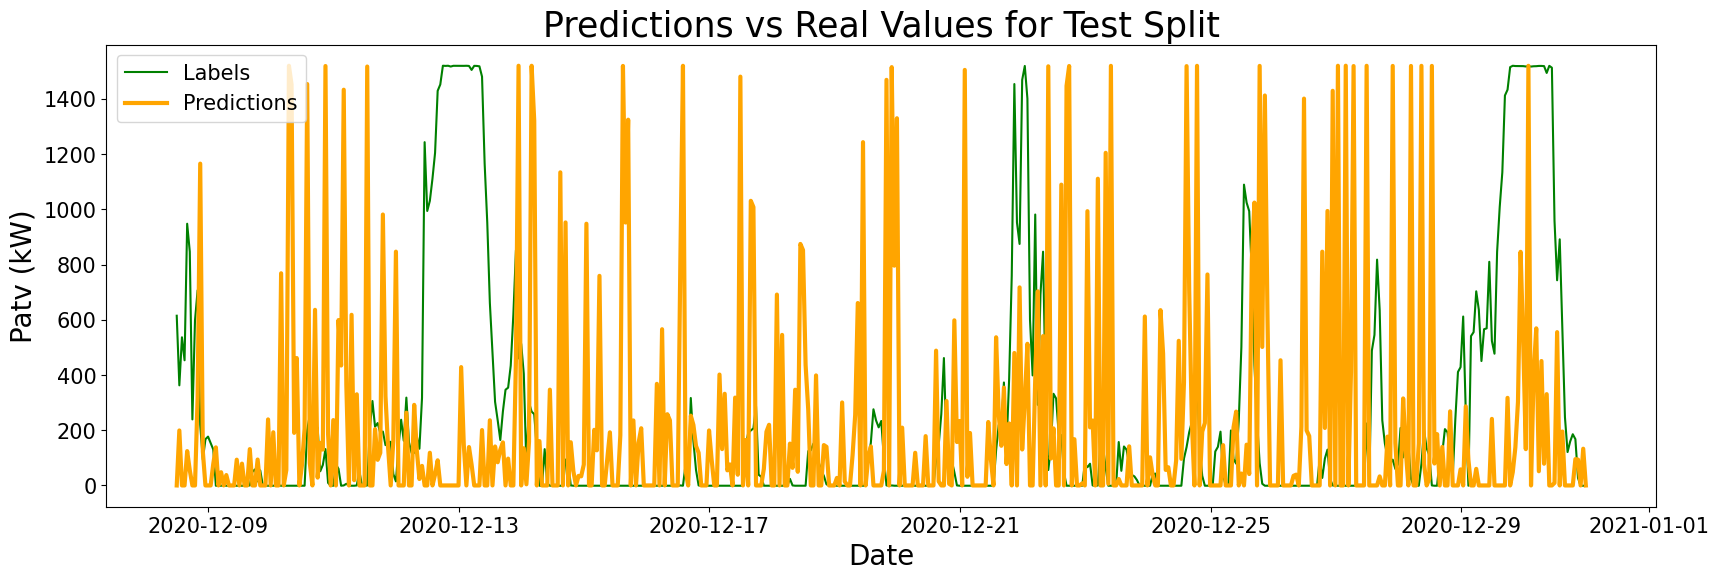

In [59]:
# Compute the random baseline
random_window, random_baseline = random_forecast(data_splits)

# Plot the predicted vs real values for the test split
random_baseline_mae = random_window.plot_long(random_baseline, data_splits)

### 15.2. Replicate the last 24 hours (tomorrow == today)

Now we will implement another simple baseline which consists of using the previous day to predict the next one, but not in any clever way, just saying "I predict tomorrow's wind power output will be the same as today".

The next cell performs this computation and shows a plot of actual vs predicted values along with some performance metrics. Note that the slider is set to 24 hours in the future, but you can change it to predict for earlier times.

In [61]:
# Create a model by predicting the next 24 hours of wind power will be the same as the previous 24 hours
interact_repeat_forecast(data_splits, baseline_mae=random_baseline_mae)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### 15.3. Compute a moving average

The next baseline we will investigate a moving average and consists of averaging the last `n_days` to obtain a prediction for a future value. For this baseline we can select the time horizon into the future that we want to predict so at any given time step. If we select 1 hour into the future we will use the previous 24 hours to predict the next hour. If we select 15 hours into the future we will use the previous 24 hours to generate the value for 15 hours into the future.

In [63]:
# Compute the baseline (try changing the n_days parameter)
moving_avg_window, moving_avg_baseline = moving_avg_forecast(data_splits, n_days=1)

# Plot the predicted vs real values for the test split
prediction_plot(moving_avg_window.plot_long, moving_avg_baseline, data_splits, baseline_mae=random_baseline_mae)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## 16. Visualize a time series of your target and predictors

For the baseline models above, we've been operating on the test set of data you created. Now, we will use the training and validations sets to develop neural network models and then evaluate them on that same test set to see how they compare to your baselines.

Before performing the actual model training we will visualize how the train, validation, and test sets look like for the target variable, which is `Patv` or active power, and the feature variables.

When we run the next cell, the target, `Patv` will appear in the top plot and we can use the pulldown menu to plot any of the feature variables in the bottom plot. Notice that abnormal values are omitted.

In [65]:
# Generate time series plot showing train, validation, and test data
plot_time_series(data_splits)

interactive(children=(Dropdown(description='Feature', options=('Wspd', 'Etmp', 'Itmp', 'Prtv', 'WdirCos', 'Wdi…

## 17. Train neural network models using historical data


### 17.1. Look at example input and output sequences

Next, we will train a model that learns patterns in the data in order to make predictions, or more specifically, a model that attempts to learn from the past to predict the future. For this, we are interested in predicting the power output for the next 24 hours into the future.

When we run the next cell, we are not doing any predictions yet. We will visualize how it would look to use different amounts of past data to predict 24 hours into the future.

For example, using the slider to choose `"Days before = 1"` will show an example of using input data 24 hours into the past to train a model that predicts energy output 24 hours into the future. Note that the data here is for demonstration purpose and not an actual prediction. We can move the `Days before` slider to visualize what it would look like to use different "windows" into the past in order to predict the future, where the window size can range from 1 to 14 days. Notice that we will get random batches of data every time you move the slider.

In [67]:
# Plot input and output sequences
window_plot(data_splits)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Days before', layout=Layout(wid…

### 17.2. Train a neural network using only the target's history
With this first iteration of modeling, we will try to predict the future of power output using only the history of the power output, or in other words, given knowledge of the power output over some number of days in the past, our model will attempt to predict the power output over the next 24 hours.

The number of days in the past that will be used to generate a future prediction is set to 1 by default but can be changed (the `days_in_past` variable below) to another value to see how that changes things.


We will use a technique called `single shot prediction`, which means that for every time step we will generate predictions of the next 24 hours. In the visualization below, we can use this output to look at what your result would be if we were attempting to use historical patterns to predict anywhere from one hour to 24 hours into the future.

Run the next cell to train a neural network to predict the power output in the future given only information about the power output in the past.

In [69]:
# Only using the target without any other predictors
features = ["Patv"]

# Compute the forecasts
window, model, _data_splits = train_conv_lstm_model(data, features, days_in_past=1)

# Plot the predicted vs real values for the test split
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### 17.3. Train a neural network using all the features history

Now we will use the same model as before but including the history of all of the features in the dataset. The visualization is the same, where we can compare our results for using historical data to predict from one hour up to 24 hours into the future.

In [70]:
# Now using all features
features = list(data.columns)

# Compute the forecasts
window, model, _data_splits = train_conv_lstm_model(data, features, days_in_past=1)

# Plot the predicted vs real values for the test split
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_1' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## 18. Include wind speed forecasts in your model

So far we have only used historical data to try to predict future values. It turns out that doesn't work very well.

There were no weather forecasts included in the original SDWPF dataset, but in a real world wind power forecasting scenario, we would certainly have forecasts to include in your modeling as well.

In this case, we can create "synthetic" wind forecasts by simply including the next day's wind data in our set of predictors that previously only included historical data. Of course, this is unrealistic because we will never have perfect knowledge of what the wind will do in the future, but let's look at this as a first step before trying to create a more realistic representation of a wind speed forecast.


### 18.1 Train a neural network model using perfect wind speed forecasts

Run the next cell to look at how the results would change if we had perfect wind speed forecasts by including the next 24 hours of wind speed data in the set of predictors.

In [72]:
# Create a new dataframe with the perfect forecasts
data_with_perfect_wspd_forecasts = add_wind_speed_forecasts(data)

# Include all features along with the external forecasts
features = list(data_with_perfect_wspd_forecasts.columns)

# Compute the power output forecasts
window, model, _data_splits = train_conv_lstm_model(data_with_perfect_wspd_forecasts, features, days_in_past=1)

# Plot the predicted vs actual values for the test split
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_2' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### 18.2 Generate "synthetic" wind speed forecasts

To generate synthetic wind speed forecasts, we will use an analysis of actual wind forecasts and measured values for three different cities taken from Open Weather's [5 day weather forecast API](https://openweathermap.org/forecast5).

The location of the wind farm that produced the SDWPF dataset was not disclosed, so we will use these forecasts from around the world to get a feeling of how much the weather forecast differs from the actual wind speed.

In [75]:
# Load the data
weather_forecasts = load_weather_forecast()

# Plot measured wind speed and forecasts for different periods into the future
plot_forecast(weather_forecasts)

interactive(children=(Dropdown(description='City', options=('Geelong, Australia', 'Porto Alegre, Brazil', 'Pit…

To understand how the forecast degrades as you try to predict further into the future, run the next cell to plot the `Mean Absolute Error` of the predicted vs. actual wind speed values from one to 120 hours into the future:

In [77]:
# Plot wind speed error as a function of hours into the future for different locations
plot_mae_forecast(weather_forecasts)

interactive(children=(Dropdown(description='City', options=('Geelong, Australia', 'Porto Alegre, Brazil', 'Pit…

Now you're ready to generate synthetic wind forecasts!

Run the cell below to create a synthetic forecast, by adding random noise to it. Then plot it to compare the actual wind measurements with synthetic forecasts with a different amount of noise added. Use the slider to add more or less noise to the wind data. Compare the MAE with the MAE from real forecasts in the plot above.

In [79]:
# Create a new dataframe with the forecasts
data_with_wspd_forecasts = add_wind_speed_forecasts(data, add_noise="linearly_increasing")

plot_forecast_with_noise(data_with_wspd_forecasts)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Noise level in m/s (low to high…

### 18.3 Train a neural network model using synthetic wind speed forecasts

Now instead of using a "perfect" weather forecast, we can use a more realistic one to train the neural network and predict the generated power. Run the cell below to see how well it works.

In [80]:
# Create a new dataframe with the external forecasts
data_with_wspd_forecasts = add_wind_speed_forecasts(data, add_noise="mimic_real_forecast")

# Include all features along with the external forecasts
features = list(data_with_wspd_forecasts.columns)

# Compute the forecasts
window, model, _data_splits = train_conv_lstm_model(data_with_wspd_forecasts, features, days_in_past=1)

# Plot the predicted vs real values for the test split
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_3' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…